# Generating the pyTDGL logo

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
from matplotlib.path import Path
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.device.mesh import ensure_unique

SAVE = False

## Define the letter geometries

In [2]:
# Letters that have loops will require more than one Polygon to define.
loops_uppercase = "ABDOPQR"
loops_lowercase = "abdegopq"

In [3]:
def interp_path(path: Path, points_per_segment: int = 11) -> np.ndarray:
    """Generate polygon coordinates for a given matplotlib Path"""
    t = np.linspace(0, 1, points_per_segment)
    segments = [
        bezier(t) for bezier, code in path.iter_bezier() if code != Path.MOVETO
    ]
    points = np.concatenate(segments)
    return ensure_unique(points)

def make_polygons(letter: str, size: int, fontprops: FontProperties) -> list[tdgl.Polygon]:
    path = TextPath((0, 0), letter, size=size, prop=fontprops)
    if letter in loops_lowercase + loops_uppercase:
        jumps = np.where(path.codes == TextPath.MOVETO)[0][1:]
        vertices = np.split(path.vertices, jumps)
        codes = np.split(path.codes, jumps)
        paths = [Path(v[:-1], c[:-1]) for v, c in zip(vertices, codes)]
    else:
        paths = [Path(path.vertices[:-1], path.codes[:-1])]
    polygons = [tdgl.Polygon(points=interp_path(p)) for p in paths]
    polygons = sorted(polygons, key=lambda p: p.area, reverse=True)
    for i, p in enumerate(polygons):
        if i == 0:
            p.name = letter
        else:
            p.name = f"{letter}_hole{i}"
    return polygons

In [4]:
fontsize = 10
fontprops = FontProperties(weight="bold")
xi = 0.4
layer = tdgl.Layer(london_lambda=5, coherence_length=xi, thickness=0.1)

In [5]:
p_outer, p_inner  = make_polygons("p", fontsize, fontprops)
y_outer,  = make_polygons("y", fontsize, fontprops)

p_device = tdgl.Device("p", layer=layer, film=p_outer, holes=[p_inner])
y_device = tdgl.Device("y", layer=layer, film=y_outer).translate(dx=6.25)

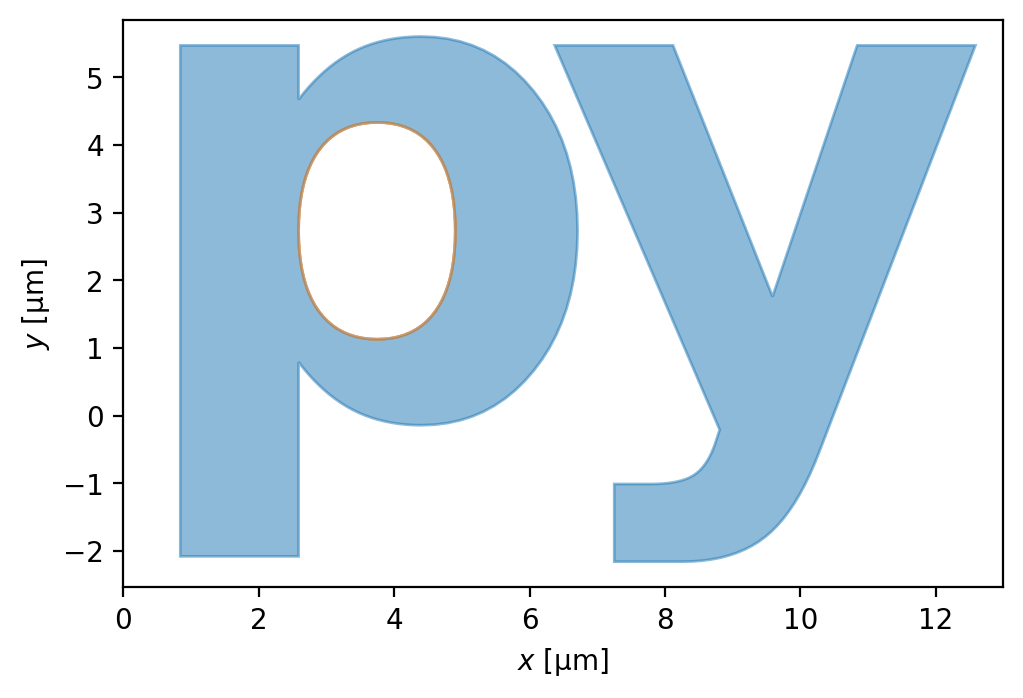

In [6]:
fig, ax = p_device.draw(legend=False)
_ = y_device.draw(ax=ax, legend=False)
_ = ax.set_xlim(0, 13)

## Generate the meshes

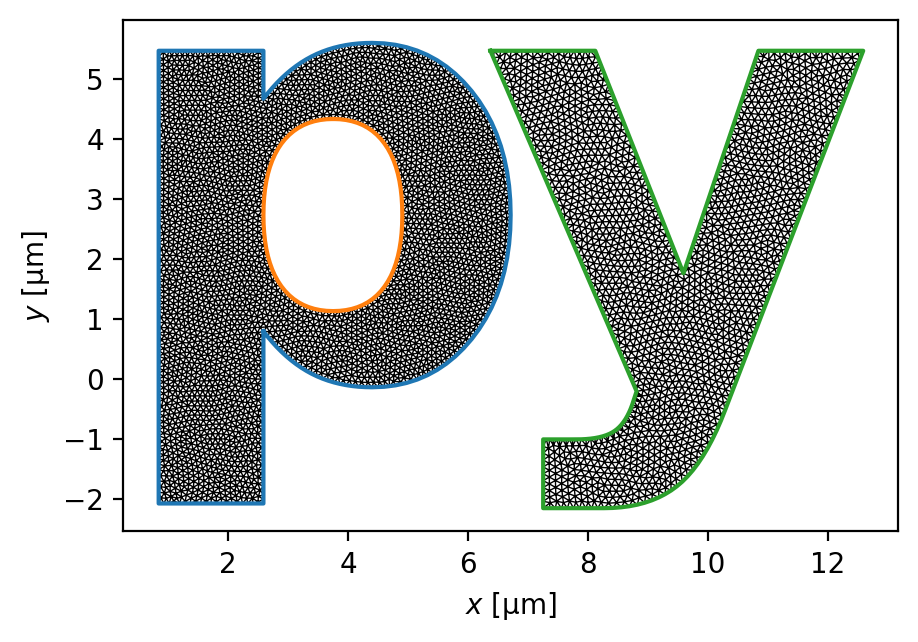

In [7]:
fig, ax = plt.subplots()
for device in (p_device, y_device):
    device.make_mesh(optimesh_steps=40, max_edge_length=xi / 2)
    device.plot(ax=ax, mesh=True, legend=False)

## Solve the models

In [8]:
dt = 1e-3
total_time = 300

kwargs = dict(
    applied_vector_potential=tdgl.sources.ConstantField(1.75),
    field_units="mT",
    include_screening=False,
)

options = tdgl.SolverOptions(
    dt_min=dt,
    dt_max=20 * dt,
    total_time=total_time,
    adaptive_window=1,
    save_every=100,
)

with tempfile.TemporaryDirectory() as d:
    p_solution = tdgl.solve(
        p_device,
        os.path.join(d, "output-p.h5"),
        options,
        **kwargs,
    )

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 300/300 [00:18<00:00, 16.03tau/s ]


In [9]:
dt = 1e-4

options = tdgl.SolverOptions(
    dt_min=dt,
    dt_max=20 * dt,
    total_time=total_time,
    adaptive_window=1,
    save_every=100,
)

with tempfile.TemporaryDirectory() as d:
    y_solution = tdgl.solve(
        y_device,
        os.path.join(d, "output-y.h5"),
        options,
        **kwargs,
    )

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████▉| 300/300 [01:13<00:00,  4.06tau/s ]


## Plot the order parameter

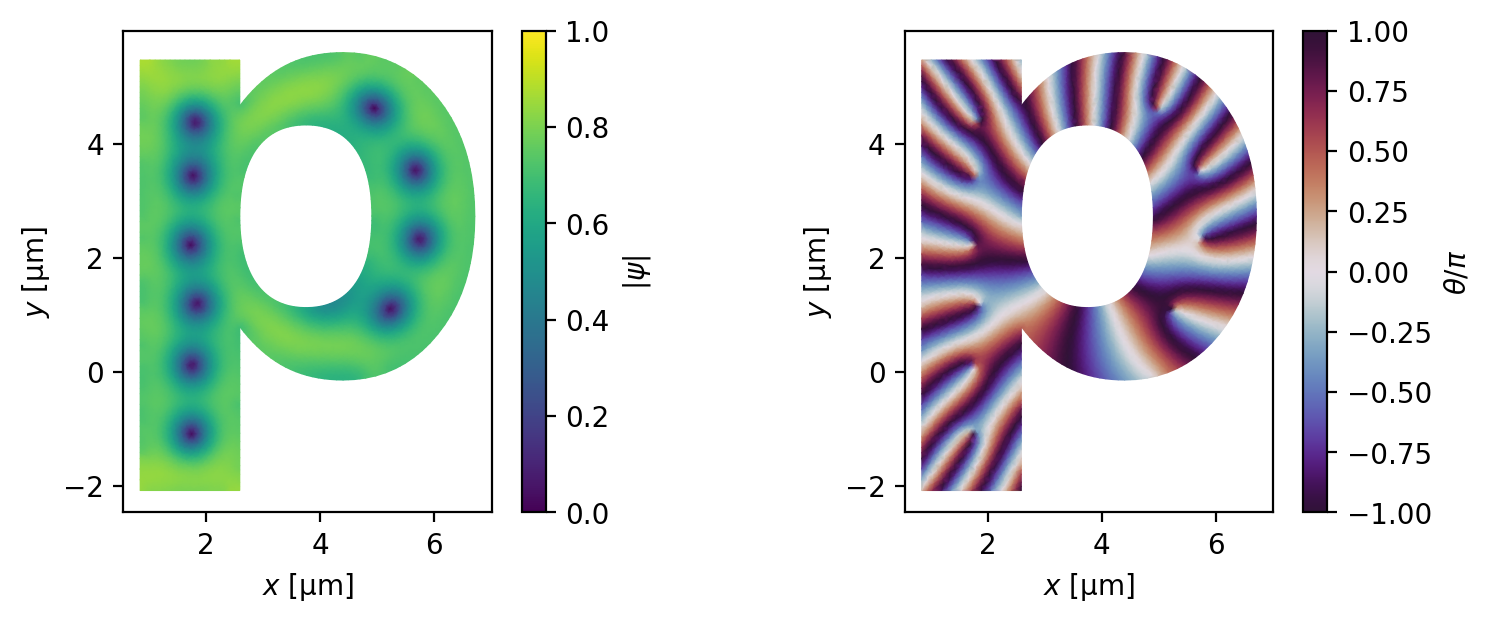

In [10]:
fig, ax = p_solution.plot_order_parameter()

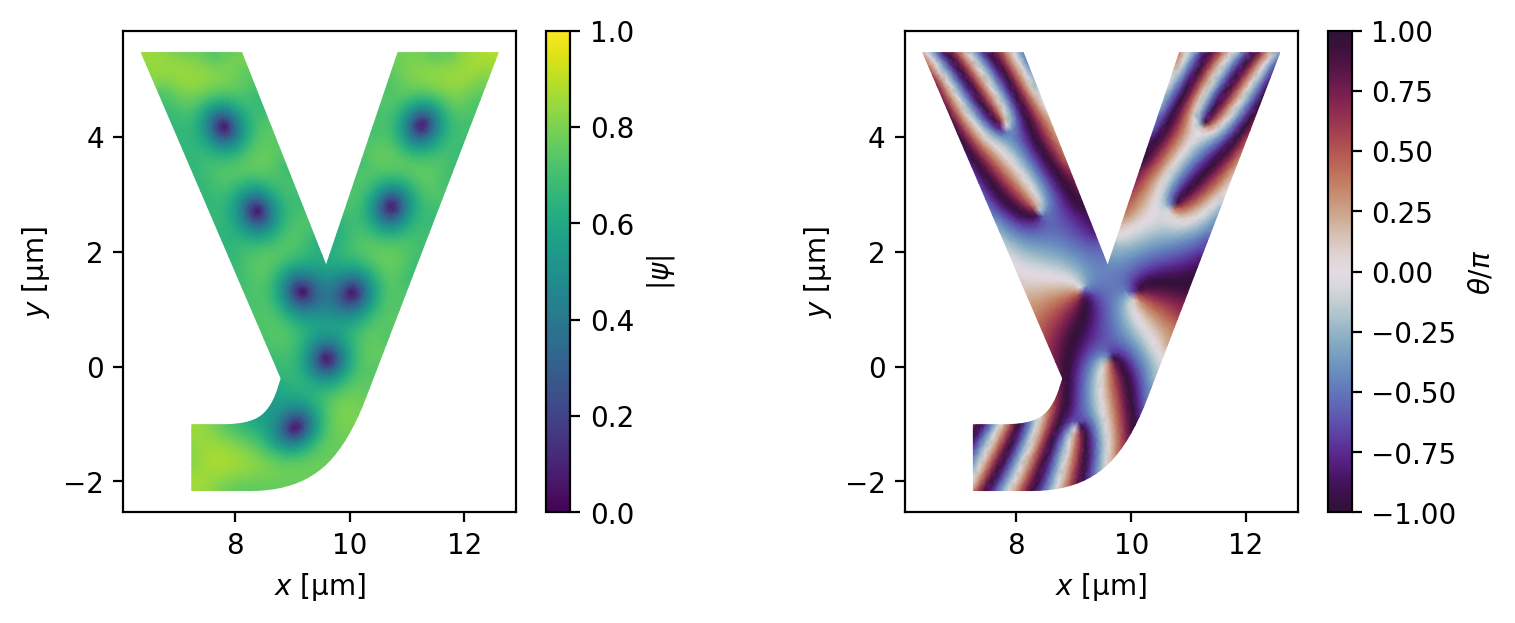

In [11]:
fig, ax = y_solution.plot_order_parameter()

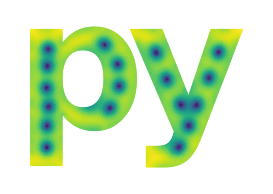

In [12]:
fig, ax = plt.subplots(figsize=(3, 1), facecolor="none")
ax.set_aspect("equal")
ax.axis("off")

for solution in (p_solution, y_solution):
    device = solution.device
    xs, ys = device.points.T
    triangles = device.triangles
    psi = solution.tdgl_data.psi
    ax.tripcolor(xs, ys, triangles, np.abs(psi), cmap="viridis", shading="gouraud")
    
if SAVE:
    fig.savefig("../images/logo-transparent-small.png", dpi=300)

In [13]:
tdgl.version_table()

Software,Version
tdgl,0.0.1
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
BLAS Info,OPENBLAS
